# Linear Regression on Bank Marketing Database

http://archive.ics.uci.edu/ml/datasets/Bank+Marketing
    
This one is very famous. Given a set of features, find the clients more suitable to make a term deposit.

In [61]:
# Better than "print" on Jupyter Notebooks
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.graphics.gofplots import qqplot

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression

%matplotlib inline

## Load file and check data

In [3]:
raw = pd.read_csv("bank.csv", sep=";")

display(raw.head())
display(raw.describe().T)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


,count,mean,std,min,25%,50%,75%,max
age,4521.0,41.170095,10.576211,19.0,33.0,39.0,49.0,87.0
balance,4521.0,1422.657819,3009.638142,-3313.0,69.0,444.0,1480.0,71188.0
day,4521.0,15.915284,8.247667,1.0,9.0,16.0,21.0,31.0
duration,4521.0,263.961292,259.856633,4.0,104.0,185.0,329.0,3025.0
campaign,4521.0,2.793630,3.109807,1.0,1.0,2.0,3.0,50.0
pdays,4521.0,39.766645,100.121124,-1.0,-1.0,-1.0,-1.0,871.0
previous,4521.0,0.542579,1.693562,0.0,0.0,0.0,0.0,25.0


## Data preparation

Job has too many categories, so we simplify it for now. Don't do that before look at your data.

In [4]:
# Reducing number of levels on "jobs"
to_job_type = {'admin.': 'white collar',
               'entrepreneur': 'white collar',
               'management': 'white collar',
               'self-employed': 'white collar',
               'blue-collar': 'blue collar',
               'services': 'blue collar',
               'technician': 'blue collar'}
raw['job_type'] = raw['job'].map(to_job_type).fillna('unknown')

## Mosaics - View Relevance on Categorical Variables

A [mosaic plot](https://en.wikipedia.org/wiki/Mosaic_plot) show the proportion of each category. A visual inspection show unbalanced categories an if the feature is a potentially

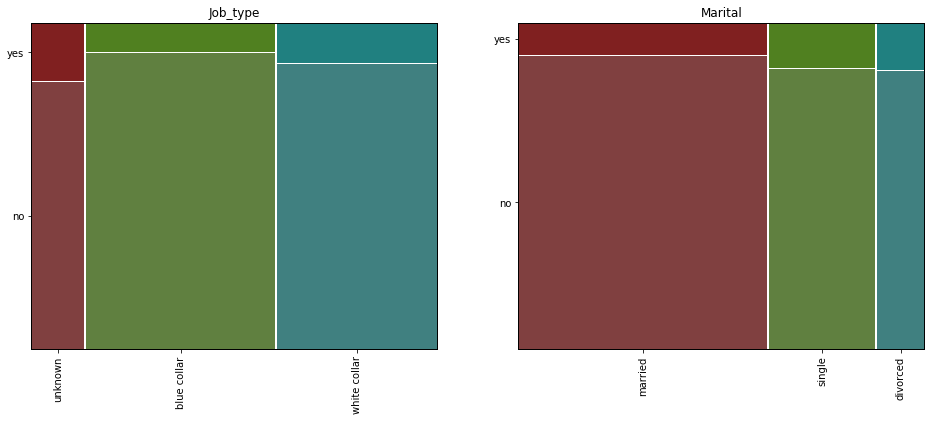

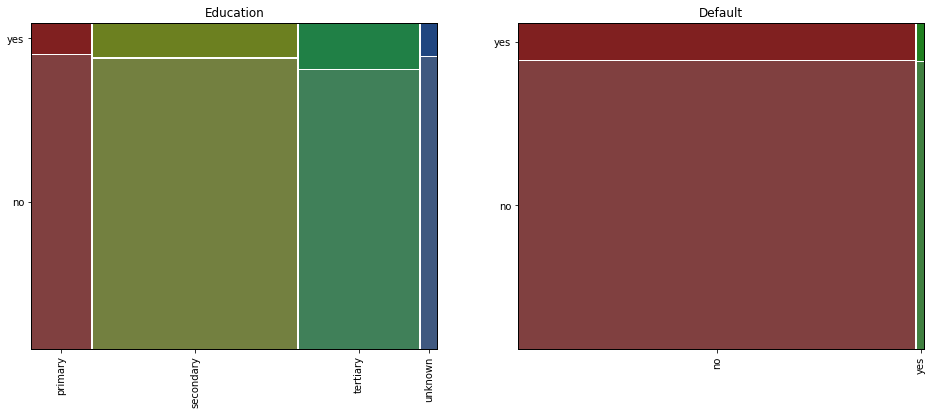

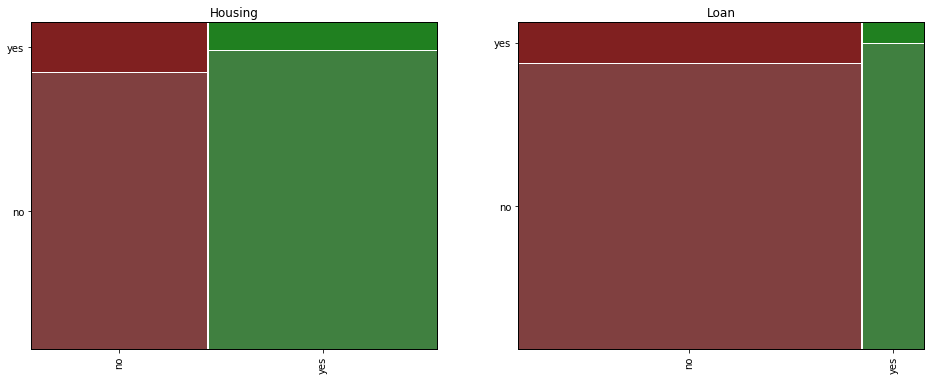

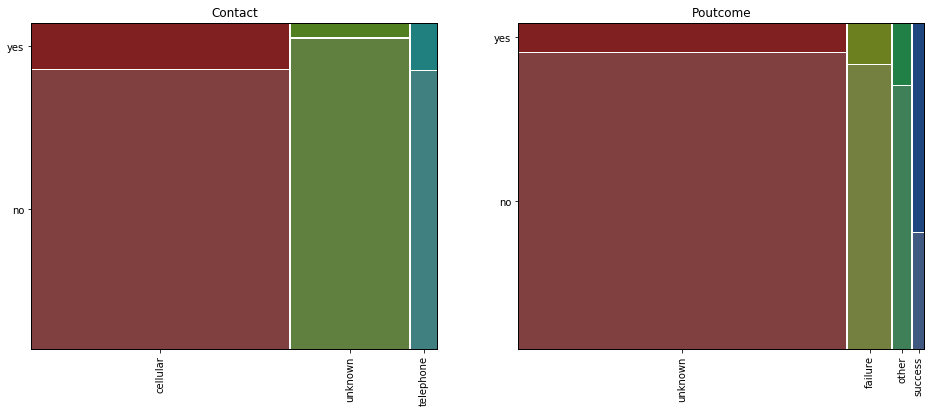

In [35]:
def mosaic_for(chart, feature_name):
    mosaic(raw, [feature_name, 'y'], 
           ax=chart,
           title=feature_name.capitalize(),
           label_rotation=[90, 0],
           labelizer=lambda k: '') 
    
fig, charts = plt.subplots(1, 2, figsize=(16, 6))
mosaic_for(charts[0], 'job_type')
mosaic_for(charts[1], 'marital')

fig, charts = plt.subplots(1, 2, figsize=(16, 6))
mosaic_for(charts[0], 'education')
mosaic_for(charts[1], 'default')

fig, charts = plt.subplots(1, 2, figsize=(16, 6))
mosaic_for(charts[0], 'housing')
mosaic_for(charts[1], 'loan')

fig, charts = plt.subplots(1, 2, figsize=(16, 6))
mosaic_for(charts[0], 'contact')
mosaic_for(charts[1], 'poutcome')

# Q-Q Plot - View Relevance on Continuous Variables

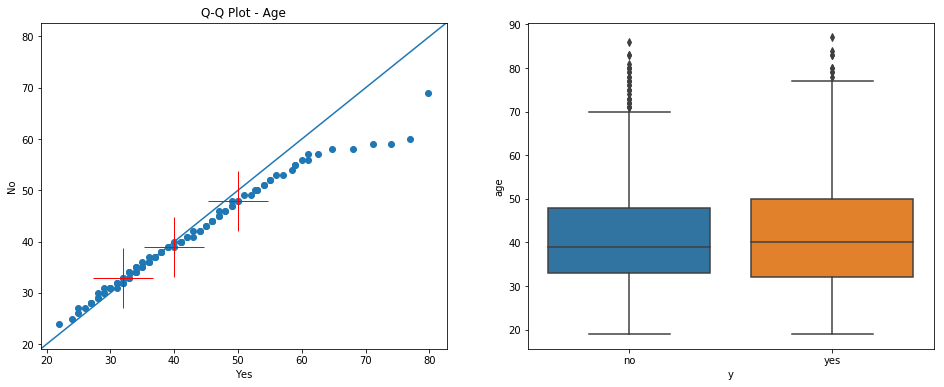

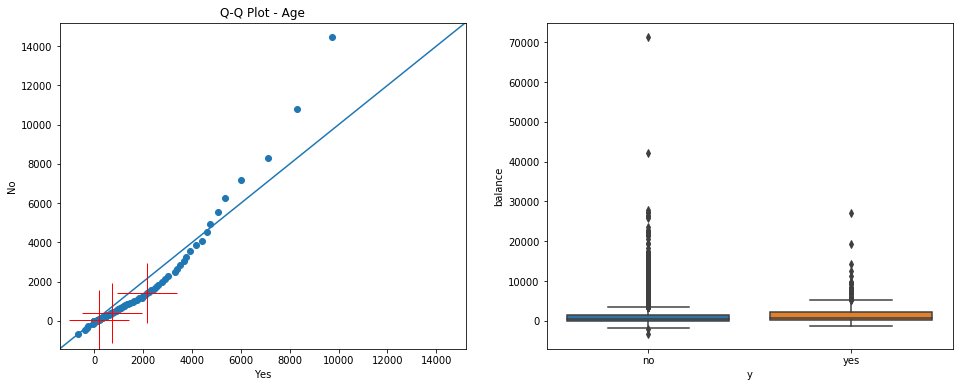

In [37]:
def qq_plot(x, y, ax, margin=0.05):
    quantiles = np.linspace(1, 99, 99)
    x_perc = np.percentile(x, q=quantiles)
    y_perc = np.percentile(y, q=quantiles)

    min_perc = min(min(x_perc), min(y_perc))
    max_perc = max(max(x_perc), max(y_perc))
    margin_perc = (max_perc - min_perc) * margin
    min_max = (min_perc - margin_perc, max_perc + margin_perc)
    
    chart1.scatter(x_perc, y_perc)
    chart1.plot(min_max, min_max)
    chart1.plot(x_perc[24], y_perc[24], "r+", markersize=60) # 1st Quartile
    chart1.plot(x_perc[49], y_perc[49], "r+", markersize=60) # Median
    chart1.plot(x_perc[74], y_perc[74], "r+", markersize=60) # 3rd Quartile
    chart1.set_xlim(min_max)
    chart1.set_ylim(min_max)
    chart1.set_xlabel('Yes')
    chart1.set_ylabel('No')
    chart1.set_title('Q-Q Plot - Age')

fig, [chart1, chart2] = plt.subplots(1, 2, figsize=(16, 6))

age_yes = raw['age'][raw['y'] == 'yes']
age_no = raw['age'][raw['y'] == 'no']

qq_plot(age_yes, age_no, ax=chart1)
sns.boxplot(data=raw, x='y', y='age', ax=chart2)


fig, [chart1, chart2] = plt.subplots(1, 2, figsize=(16, 6))

balance_yes = raw['balance'][raw['y'] == 'yes']
balance_no = raw['balance'][raw['y'] == 'no']

qq_plot(balance_yes, balance_no, ax=chart1)
sns.boxplot(data=raw, x='y', y='balance', ax=chart2);

## Dummy Variables (One Hot Encoding)

We need to transform categorical variables in multiple features with 0, 1.

In [46]:
desired_columns = ['age', 'job_type', 'marital', 'education', 'balance', 'housing', 'loan', 'poutcome']
dummy_columns = ['job', 'marital', 'education', 'housing', 'loan', 'poutcome']
ready = pd.get_dummies(raw[desired_columns], dummy_columns)

# Mapping "yes", "no" to 1 and 0, default to 0 if no info
ready['target'] = raw['y'].map({'no': 0, 'yes': 1}).fillna(0)

ready.head()

,age,balance,job_blue collar,job_unknown,job_white collar,marital_divorced,marital_married,marital_single,education_primary,education_secondary,...,education_unknown,housing_no,housing_yes,loan_no,loan_yes,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,target
0,30,1787,0,1,0,0,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
1,33,4789,1,0,0,0,1,0,0,1,...,0,0,1,0,1,1,0,0,0,0
2,35,1350,0,0,1,0,0,1,0,0,...,0,0,1,1,0,1,0,0,0,0
3,30,1476,0,0,1,0,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
4,59,0,1,0,0,0,1,0,0,1,...,0,0,1,1,0,0,0,0,1,0


In [71]:
features = ready.iloc[:,0:-1]
target = ready.iloc[:,-1]

model = LogisticRegression()
scores = cross_validate(model, features, target, cv=10,
                        scoring=['precision_macro', 'recall_macro'],
                        return_train_score=False)

display(scores['test_precision_macro'].mean())
display(scores['test_recall_macro'].mean())

0.7757497231005106

0.5581230043541364